This is the Deepnote File 

In [ ]:
#We all ready?
#Let's use this for general stuff, remarks and comments - just comment them here. 


# 

In [ ]:
import pandas as pd
import numpy as np
from scipy import stats
from numpy import array
from numpy import vstack
from pandas import read_csv
from pandas import DataFrame
from numpy import dstack
from numpy import unique
from pandas import read_csv
from matplotlib import pyplot
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers import Dropout
from keras.layers import LSTM
from keras.utils import to_categorical



# Load Dataset

In [ ]:
#Build a Dataloader function
from pandas import read_csv
from numpy import dstack

def dataloader(d_path):
	dataframe = read_csv(d_path, header=None, delim_whitespace=True)
	return dataframe.values

data = dataloader('/work/CrispCerebella/Dataset/UCI HAR Dataset/train/Inertial Signals/total_acc_y_train.txt')

print(data.shape)

# function to load a group of data and create a 3 dimentional tensor out of it
def dataloader_group(filenames, prefix=''):
	loaded = list()
	for name in filenames:
		data = dataloader(prefix + name)
		loaded.append(data)
	# create a 3 dimentional tensor out of the individual data files
	loaded = dstack(loaded)
	return loaded

# load all acc data into a 3 dimentinal tensor 
acc_filenames = ['total_acc_x_train.txt', 'total_acc_y_train.txt', 'total_acc_z_train.txt']
total_acc_xyz = dataloader_group(acc_filenames, prefix='/work/CrispCerebella/Dataset/UCI HAR Dataset/train/Inertial Signals/')
print(total_acc_xyz.shape)

# create a train and test group out of the data
def datasetloader(group, prefix=''):
	filepath = prefix + group + '/Inertial Signals/'
	filenames = list()
	# filenames: total acceleration
	filenames += ['total_acc_x_'+group+'.txt', 'total_acc_y_'+group+'.txt', 'total_acc_z_'+group+'.txt']
	# filenames: body acceleration
	filenames += ['body_acc_x_'+group+'.txt', 'body_acc_y_'+group+'.txt', 'body_acc_z_'+group+'.txt']
	# filenames: body gyroscope
	filenames += ['body_gyro_x_'+group+'.txt', 'body_gyro_y_'+group+'.txt', 'body_gyro_z_'+group+'.txt']
	# load X data (input)
	X = dataloader_group(filenames, filepath)
	# load output labels
	y = dataloader(prefix + group + '/y_'+group+'.txt')
	return X, y
 
# load all train
trainX, trainy = datasetloader('train', '/work/CrispCerebella/Dataset/UCI HAR Dataset/')
print("Shape of training Data:",trainX.shape, trainy.shape)
# load all test
testX, testy = datasetloader('test', '/work/CrispCerebella/Dataset/UCI HAR Dataset/')
print("Shape of test Data:",testX.shape, testy.shape)
 


(7352, 128)
(7352, 128, 3)
Shape of training Data: (7352, 128, 9) (7352, 1)
Shape of test Data: (2947, 128, 9) (2947, 1)


In [ ]:

#In this section we will assign the classes (which correspond the motions 1-6)
# to each row of the 128 data points.
# summarize the balance of classes in an output variable column
def class_breakdown(data):
	# convert the numpy array into a dataframe
	df = DataFrame(data)
	# group data by the class value and calculate the number of rows
	counts = df.groupby(0).size()
	# retrieve raw rows
	counts = counts.values
	# summarize
	for i in range(len(counts)):
		percent = counts[i] / len(df) * 100
		print('Class=%d, total=%d, percentage=%.3f' % (i+1, counts[i], percent))
 
# load train file
# summarize class breakdown
print('Train Dataset')
class_breakdown(trainy)
 
# load test file
# summarize class breakdown
print('Test Dataset')
class_breakdown(testy)
 
# summarize combined class breakdown
print('Both')
combined = vstack((trainy, testy))
class_breakdown(combined)

Train Dataset
Class=1, total=1226, percentage=16.676
Class=2, total=1073, percentage=14.595
Class=3, total=986, percentage=13.411
Class=4, total=1286, percentage=17.492
Class=5, total=1374, percentage=18.689
Class=6, total=1407, percentage=19.138
Test Dataset
Class=1, total=496, percentage=16.831
Class=2, total=471, percentage=15.982
Class=3, total=420, percentage=14.252
Class=4, total=491, percentage=16.661
Class=5, total=532, percentage=18.052
Class=6, total=537, percentage=18.222
Both
Class=1, total=1722, percentage=16.720
Class=2, total=1544, percentage=14.992
Class=3, total=1406, percentage=13.652
Class=4, total=1777, percentage=17.254
Class=5, total=1906, percentage=18.507
Class=6, total=1944, percentage=18.876


[ 1  3  5  6  7  8 11 14 15 16 17 19 21 22 23 25 26 27 28 29 30]
(347, 128, 9) (347, 1)


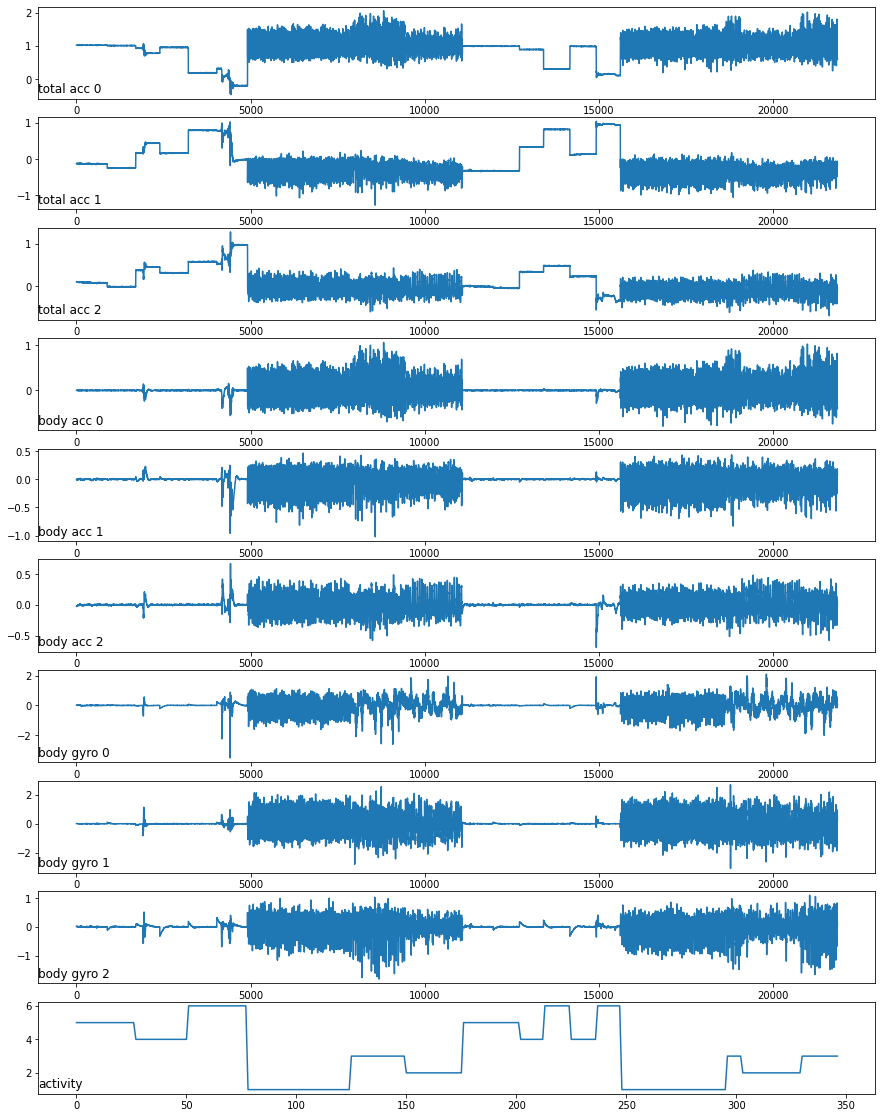

In [ ]:
# get all data for one subject
def data_for_subject(X, y, sub_map, sub_id):
	# get row indexes for the subject id
	ix = [i for i in range(len(sub_map)) if sub_map[i]==sub_id]
	# return the selected samples
	return X[ix, :, :], y[ix]
 
# convert a series of windows to a 1D list
def to_series(windows):
	series = list()
	for window in windows:
		# remove the overlap from the window
		half = int(len(window) / 2) - 1
		for value in window[-half:]:
			series.append(value)
	return series
 
# plot the data for one subject
def plot_subject(X, y):
	pyplot.figure(figsize=(15,20))
	# determine the total number of plots
	n, off = X.shape[2] + 1, 0
	# plot total acc
	for i in range(3):
		pyplot.subplot(n, 1, off+1)
		pyplot.plot(to_series(X[:, :, off]))
		pyplot.title('total acc '+str(i), y=0, loc='left')
		off += 1
	# plot body acc
	for i in range(3):
		pyplot.subplot(n, 1, off+1)
		pyplot.plot(to_series(X[:, :, off]))
		pyplot.title('body acc '+str(i), y=0, loc='left')
		off += 1
	# plot body gyro
	for i in range(3):
		pyplot.subplot(n, 1, off+1)
		pyplot.plot(to_series(X[:, :, off]))
		pyplot.title('body gyro '+str(i), y=0, loc='left')
		off += 1
	# plot activities
	pyplot.subplot(n, 1, n)
	pyplot.plot(y)
	pyplot.title('activity', y=0, loc='left')
 
# load data
pyplot.show()
# load mapping of rows to subjects
sub_map = dataloader('/work/CrispCerebella/Dataset/UCI HAR Dataset/train/subject_train.txt')
train_subjects = unique(sub_map)
print(train_subjects)
# get the data for one subject
sub_id = train_subjects[0]
subX, suby = data_for_subject(trainX, trainy, sub_map, sub_id)
print(subX.shape, suby.shape)

# plot data for subject
plot_subject(subX, suby)

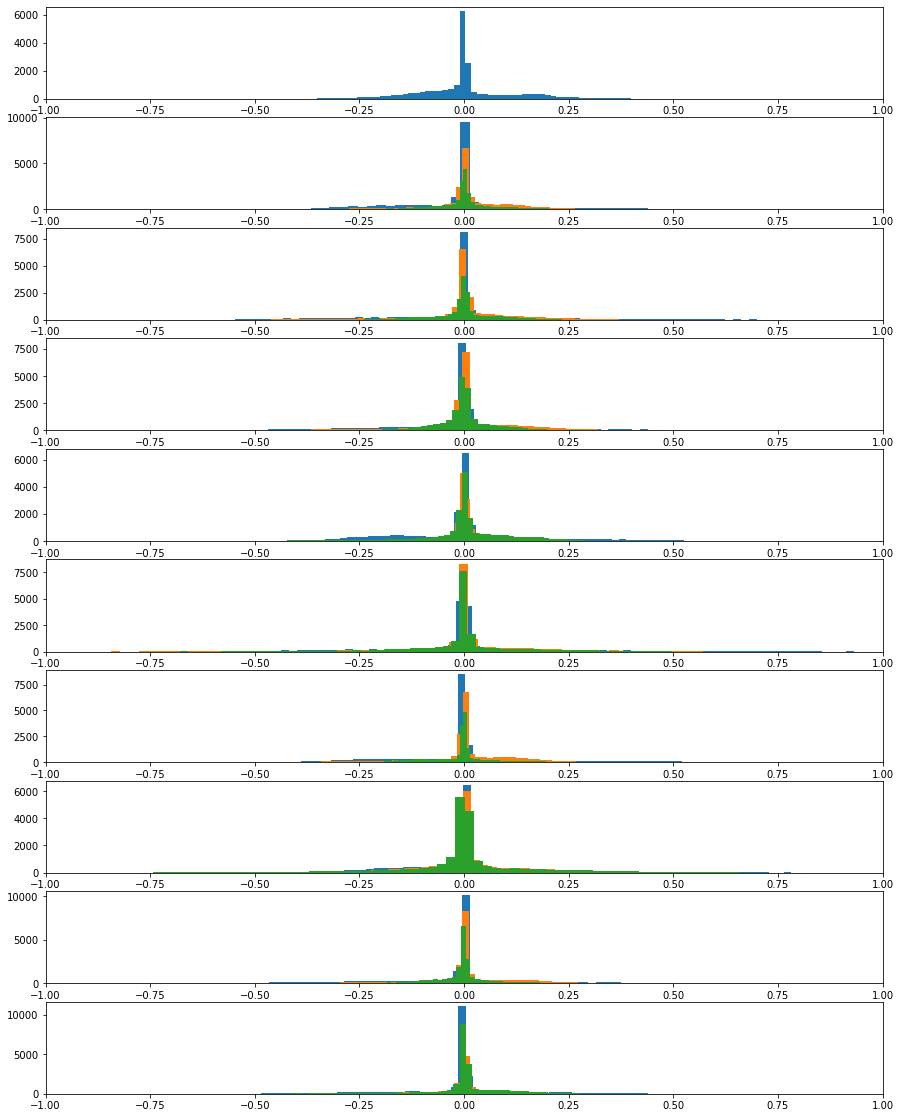

In [ ]:

# plot histograms for multiple subjects
def plot_subject_histograms(X, y, sub_map, n=10):
	pyplot.figure(figsize=(15,20))
	# get unique subjects
	subject_ids = unique(sub_map[:,0])
	# enumerate subjects
	xaxis = None
	for k in range(n):
		sub_id = subject_ids[k]
		# get data for one subject
		subX, _ = data_for_subject(X, y, sub_map, sub_id)
		# body acc
		for i in range(3):
			ax = pyplot.subplot(n, 1, k+1, sharex=xaxis)
			ax.set_xlim(-1,1)
			if k == 0:
				xaxis = ax
			pyplot.hist(to_series(subX[:,:,3+i]), bins=100)
	pyplot.show()
 
# load training dataset
X,y = datasetloader('train','/work/CrispCerebella/Dataset/UCI HAR Dataset/')

# plot histograms for subjects
plot_subject_histograms(X, y, sub_map)

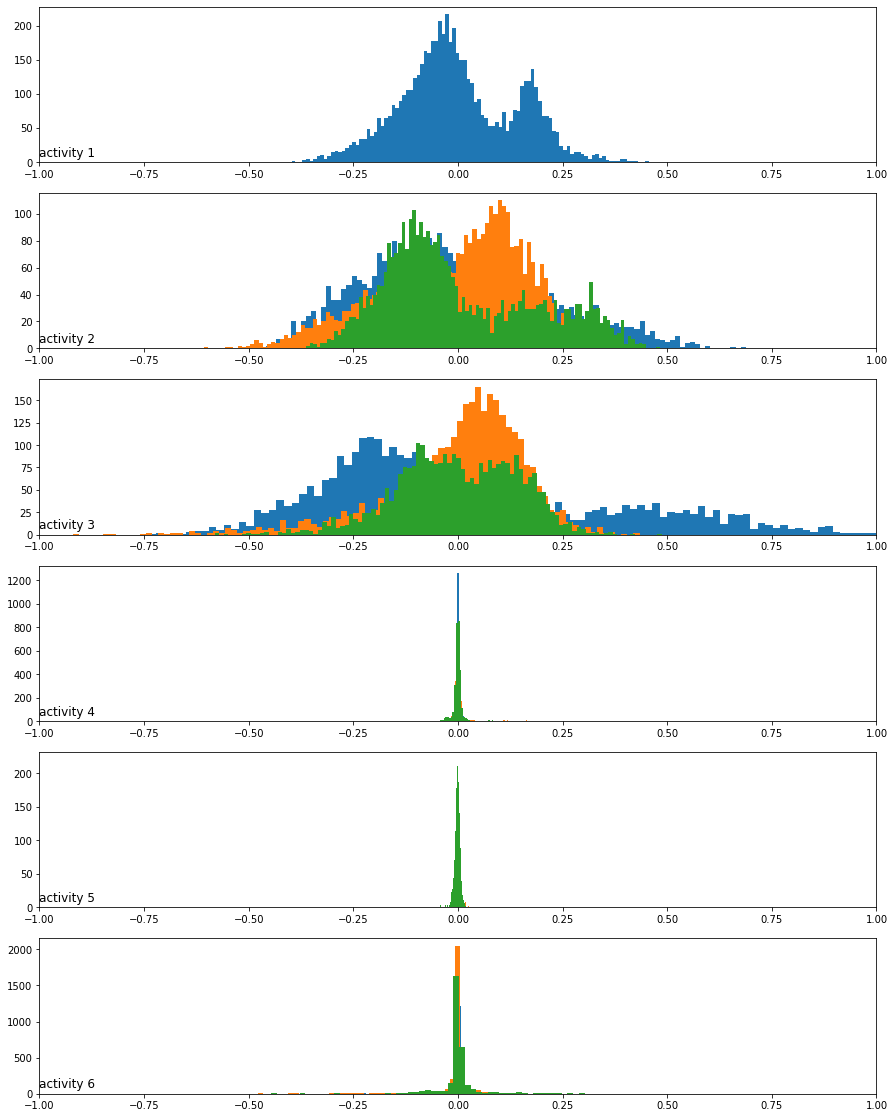

In [ ]:
# group data by activity
def data_by_activity(X, y, activities):
	# group windows by activity
	return {a:X[y[:,0]==a, :, :] for a in activities}
 
# plot histograms for each activity for a subject
def plot_activity_histograms(X, y):
	# get a list of unique activities for the subject
	activity_ids = unique(y[:,0])
	# group windows by activity
	grouped = data_by_activity(X, y, activity_ids)
	# plot per activity, histograms for each axis
	pyplot.figure(figsize=(15,20))
	xaxis = None
	for k in range(len(activity_ids)):
		act_id = activity_ids[k]
		# total acceleration
		for i in range(3):
			ax = pyplot.subplot(len(activity_ids), 1, k+1, sharex=xaxis)
			ax.set_xlim(-1,1)
			if k == 0:
				xaxis = ax
			pyplot.hist(to_series(grouped[act_id][:,:,3+i]), bins=100)
			pyplot.title('activity '+str(act_id), y=0, loc='left')
	pyplot.show()

# get the data for one subject
sub_id = train_subjects[0]
subX, suby = data_for_subject(trainX, trainy, sub_map, sub_id)
# plot data for subject
plot_activity_histograms(subX, suby)

# Prepare Dataset

# Test Model

In [ ]:
# load the dataset, returns train and test X and y elements
def transform_dataset(trainX, trainy, testX, testy):
	print(trainX.shape, trainy.shape)
	print(testX.shape, testy.shape)
	# zero-offset class values
	trainy = trainy - 1
	testy = testy - 1
	# one hot encode y
	trainy = to_categorical(trainy)
	testy = to_categorical(testy)
	print(trainX.shape, trainy.shape, testX.shape, testy.shape)
	return trainX, trainy, testX, testy

In [ ]:
# fit and evaluate a model
def evaluate_model(trainX, trainy, testX, testy):
	verbose, epochs, batch_size = 0, 15, 64
	n_timesteps, n_features, n_outputs = trainX.shape[1], trainX.shape[2], trainy.shape[1]
	model = Sequential()
	model.add(LSTM(100, input_shape=(n_timesteps,n_features)))
	model.add(Dropout(0.5))
	model.add(Dense(100, activation='relu'))
	model.add(Dense(n_outputs, activation='softmax'))
	model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
	# fit network
	model.fit(trainX, trainy, epochs=epochs, batch_size=batch_size, verbose=verbose)
	# evaluate model
	_, accuracy = model.evaluate(testX, testy, batch_size=batch_size, verbose=0)
	return accuracy

In [ ]:

# summarize scores
def summarize_results(scores):
	print(scores)
	m, s = mean(scores), std(scores)
	print('Accuracy: %.3f%% (+/-%.3f)' % (m, s))

In [ ]:
# run an experiment
def run_experiment(trainX, trainy, testX, testy, repeats=10):
	# load data
	trainX, trainy, testX, testy = transform_dataset(trainX, trainy, testX, testy)
	# repeat experiment
	scores = list()
	for r in range(repeats):
		score = evaluate_model(trainX, trainy, testX, testy)
		score = score * 100.0
		print('>#%d: %.3f' % (r+1, score))
		scores.append(score)
	# summarize results
	summarize_results(scores)

In [ ]:
# run the experiment
run_experiment(trainX, trainy, testX, testy)

(7352, 128, 9) (7352, 1)
(2947, 128, 9) (2947, 1)
(7352, 128, 9) (7352, 6) (2947, 128, 9) (2947, 6)
>#1: 90.329
>#2: 89.311
>#3: 90.974
>#4: 89.277
>#5: 90.465
>#6: 90.736
>#7: 90.567
>#8: 90.872
>#9: 89.243
>#10: 91.076
[90.32914638519287, 89.31116461753845, 90.97387194633484, 89.27723169326782, 90.46487808227539, 90.73634147644043, 90.56667685508728, 90.87207317352295, 89.24329876899719, 91.07567071914673]


NameError: name 'mean' is not defined

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=0bc38299-d7dc-427d-847e-3f965a2d07ef' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>